# A Demonstration of Numba's new reference count pruner

In [1]:
from IPython.display import Image  # for displaying images

A new reference counting pruner (aka refpruner) is added in Numba 0.52.0 to do a better job of removing redundant reference counting (refcounts). The new refpruner is written as an LLVM compiler pass that operates on the LLVM IR that Numba generates. Comparing to the old refpruner (pre-0.52), which could only analyze basic blocks, the new implementation detects redundant reference counting operation in the control-flow graph (CFG).

The refpruner can prune four common patterns and these can be configured via the [`NUMBA_LLVM_REFPRUNE_FLAGS` environment variable](https://numba.readthedocs.io/en/stable/reference/envvars.html#envvar-NUMBA_LLVM_REFPRUNE_FLAGS). Throughout this demonstration JIT code is written into a file and then run with the various pruning patterns specified via this flag. Then Numba's new CFG visualization capability is used to show the control flow graph of the LLVM IR with various parts highlighted such that the effect of using the refpruner can be seen. Further some data, `PruneStats`, is printed to show how many refcounts were removed for each pattern.

Note: Within each control flow graph, `NRT_incref(X)` (incref) corresponds to incrementing the reference count of variable `X`, and `NRT_decref(X)` (decref) corresponds to decrementing the reference count of variable `X`. These incref/decref "pairs" are what the refpruner is attempting to remove, along with decref on `NULL` (a no-op), and it will only do this removal if it is safe. Recall that erroneous removal of reference counts can lead to memory leaks, segfaults and/or corruption!

## Pattern 1: Per Basic-Block

The per-basicblock pattern prunes within each basic block and does not depend on the control-flow graph. It corresponds to a straight line sequence of code that performs refcounts. The old refpruner supports this pattern only.

In [2]:
%%writefile perbb.py

from numba import njit

@njit
def per_bb():
    a = "a"
    return a + a + a

# Run to trigger compilation
per_bb()
# Render the control-flow graph to file
per_bb.inspect_cfg(per_bb.signatures[0], strip_ir=True).display(filename='perbb', format='png')
# The following reports on the number of refcount operations pruned
print(per_bb.get_metadata(per_bb.signatures[0])['prune_stats'])

Overwriting perbb.py


### Without Refprune

In [3]:
!NUMBA_LLVM_REFPRUNE_FLAGS= python -Wignore perbb.py

PruneStats(basicblock=0, diamond=0, fanout=0, fanout_raise=0)


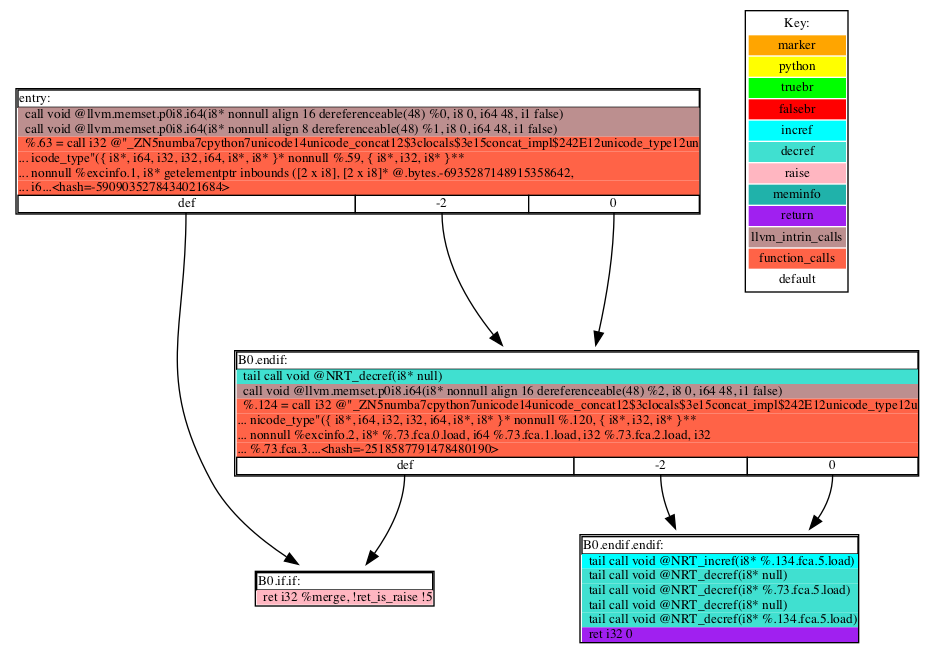

In [4]:
Image(filename='perbb.png') 

### With Refprune

In [5]:
!NUMBA_LLVM_REFPRUNE_FLAGS=per_bb python perbb.py

PruneStats(basicblock=9, diamond=0, fanout=0, fanout_raise=0)


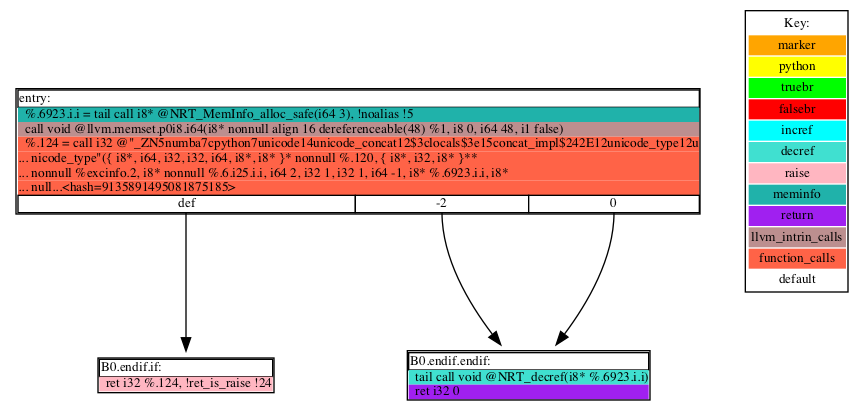

In [6]:
Image(filename='perbb.png') 

Comparing `B0.endif.endif` block in the two CFG outputs, you can see that the `NRT_incref` and all `NRT_decref(i8* null)` are gone.

### Implementation notes

This pattern is very easy to spot once the refcount operations are reordered so that all decrefs in the basic-block are after the increfs. Any incref-decref pairs that operate on the same SSA name are pruned. This pattern also prunes any refcounting operations on `NULL`, which can appear after some LLVM optimizations.

## Pattern 2: Diamond

The diamond pattern is for the fork-then-merge subgraph. It is common for if-else code to create this pattern.

In [7]:
%%writefile diamond.py

from numba import njit, typed

@njit
def diamond(lst):
    if len(lst):
        # Using non-raising version of getitem.
        x = lst.getitem_unchecked(0)
    else:
        x = 0
    return x

    
diamond(typed.List([1]))
diamond.inspect_cfg(diamond.signatures[0], strip_ir=True).display(filename='diamond', format='png')

Overwriting diamond.py


### Without Refprune

In [8]:
!NUMBA_LLVM_REFPRUNE_FLAGS=per_bb python diamond.py

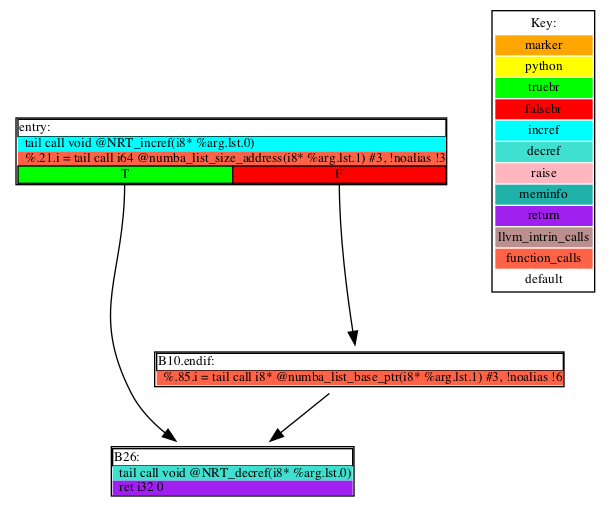

In [9]:
Image(filename='diamond.png') 

### With Refprune

In [10]:
!NUMBA_LLVM_REFPRUNE_FLAGS=per_bb,diamond python diamond.py

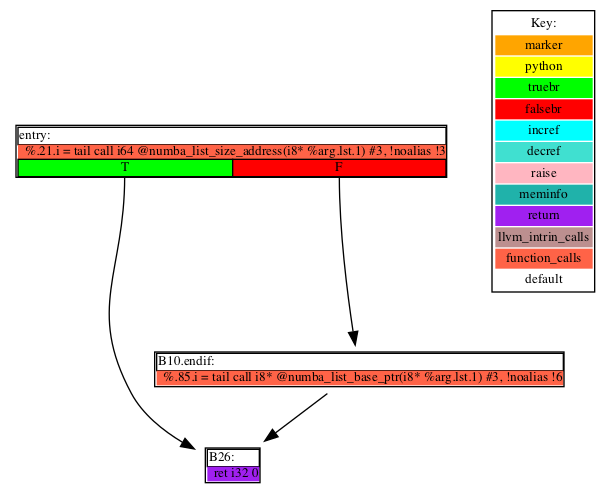

In [11]:
Image(filename='diamond.png') 

The incref in `entry` and the decref in `B26` is pruned.

### Implementation notes

This pattern is relatively cheap to detect by using the dominator tree and post-dominator tree in LLVM. The incref must dominate the decref and the decref must post-dominate the incref. Since the pass relies on the SSA name for the same object, we must consider that some other SSA names might be aliasing the same object. We conservatively reject the subgraph if any other decref operations are in the subgraph. Also, we need to check that the decref is not inside a cycle that is dominated by the incref.

## Pattern 3: Fanout

The fanout pattern involves subgraphs that start with an incref and then spread out into multiple subtrees that have decrefs at the exit node of the subgraph. Return statements within if-else trees are likely to create this pattern.

In [12]:
%%writefile fanout.py

from numba import njit
from numba.typed import Dict



@njit
def fanout(da, db):
    if len(da) != len(db):
        return False
    for ka, va in da.items():
        # The incref starts here
        vb = db.get(ka)
        if vb is None:
            # Exit node
            return False
        elif va != vb:
            # Exit node
            return False
    return True
    
    
d = Dict()
d.update({i: 1 for i in range(3)})

fanout(d, d)
fanout.inspect_cfg(fanout.signatures[0], strip_ir=True).display(filename='fanout', format='png')
print(fanout.get_metadata(fanout.signatures[0])['prune_stats'])

Overwriting fanout.py


In [13]:
!NUMBA_LLVM_REFPRUNE_FLAGS=per_bb,diamond python fanout.py

PruneStats(basicblock=20, diamond=2, fanout=0, fanout_raise=0)


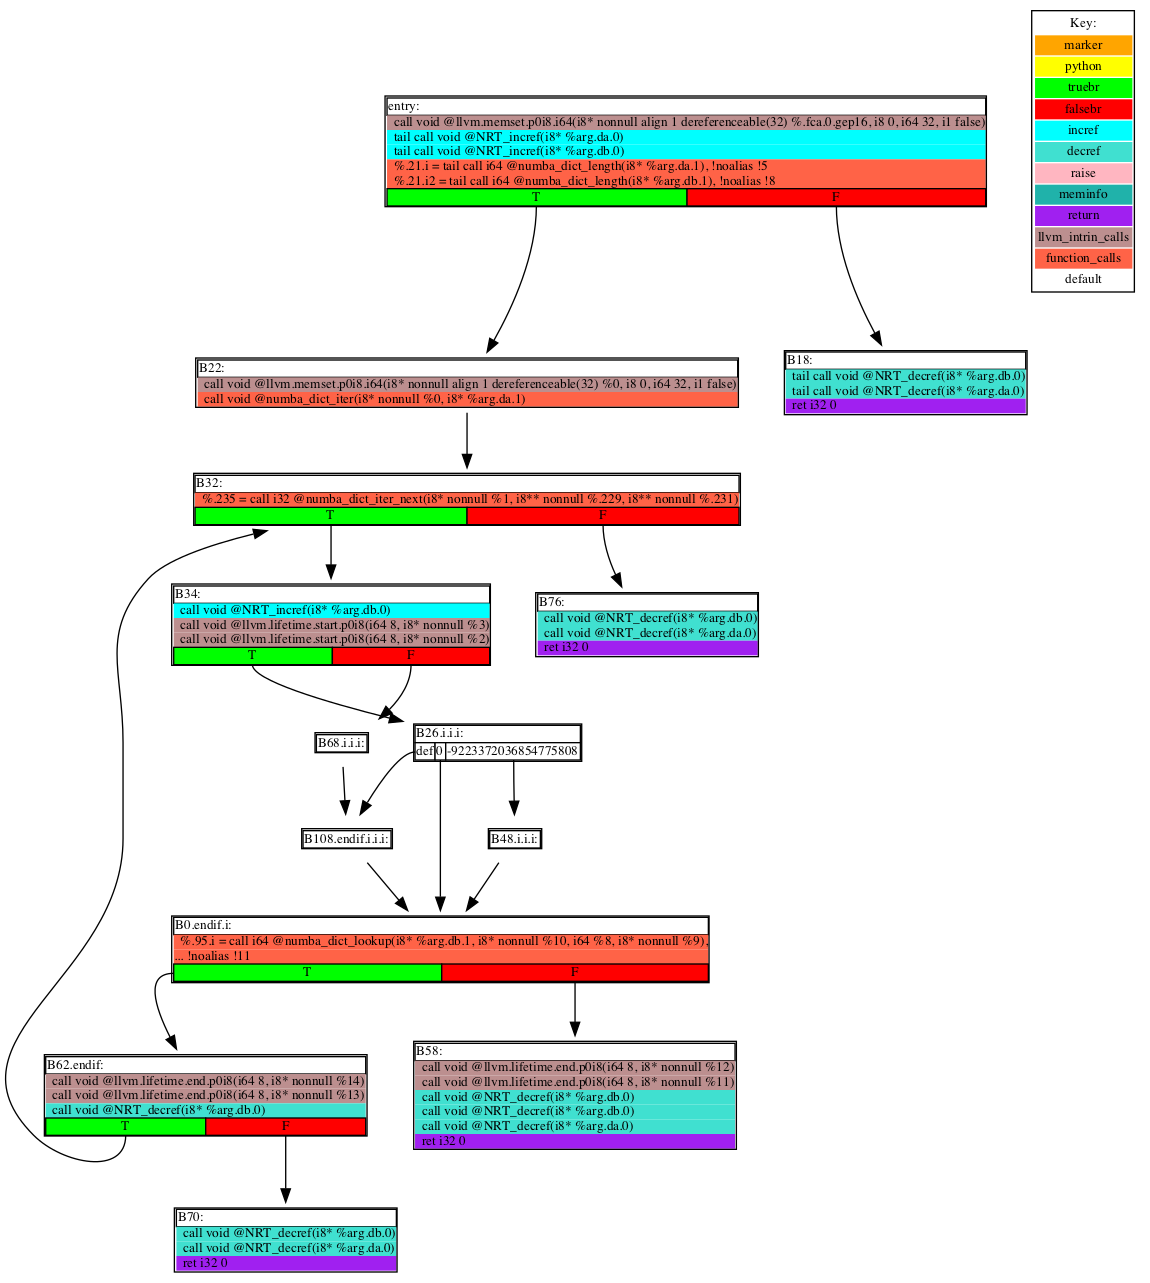

In [14]:
Image(filename='fanout.png') 

In [15]:
!NUMBA_LLVM_REFPRUNE_FLAGS=per_bb,diamond,fanout python fanout.py

PruneStats(basicblock=20, diamond=2, fanout=13, fanout_raise=0)


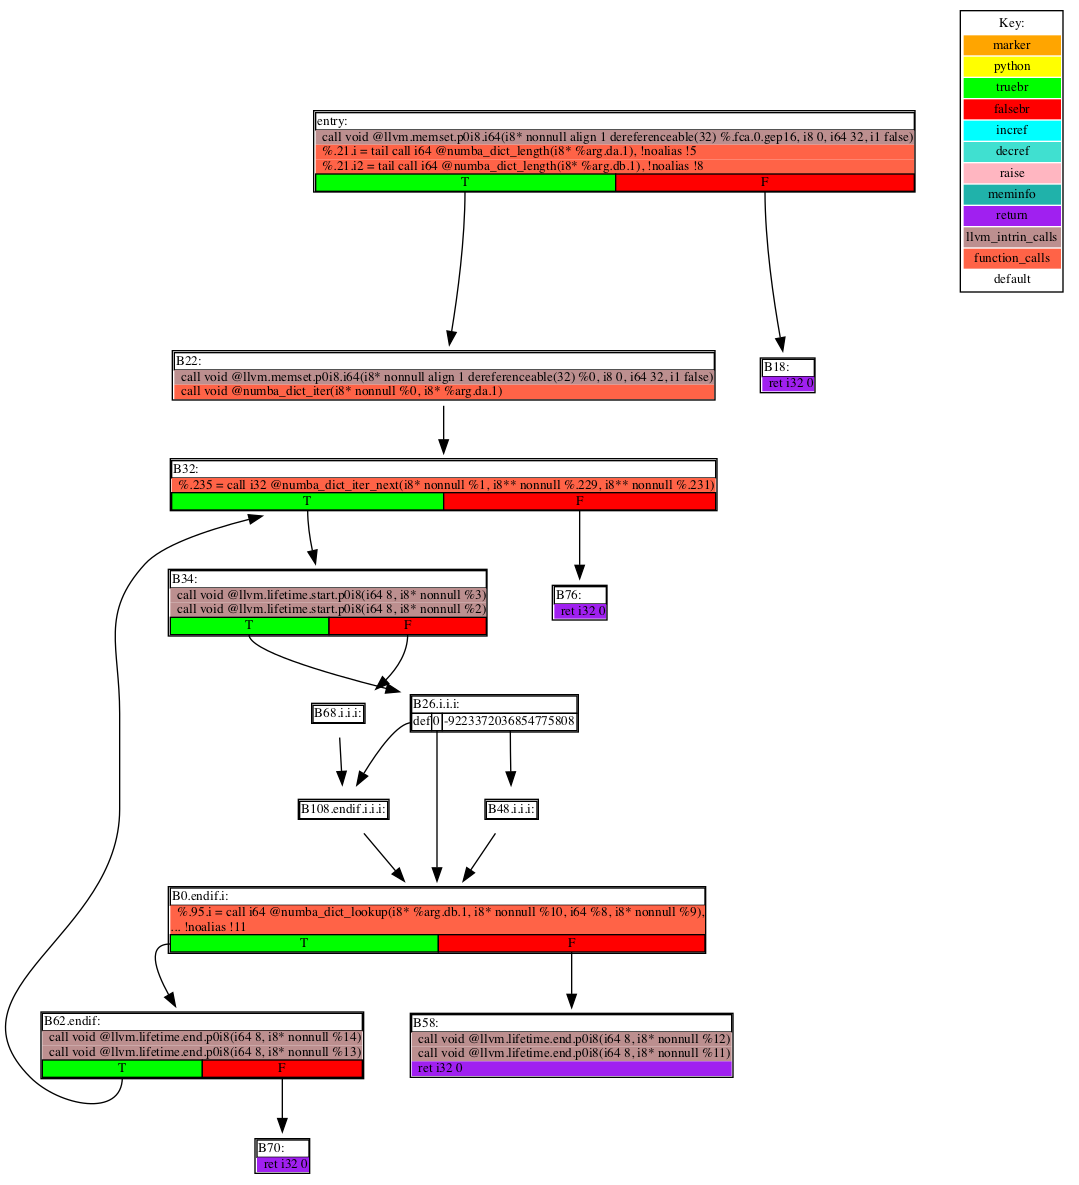

In [16]:
Image(filename='fanout.png') 

You can see that the variable `%arg.db.0` no longer requires any refcount operations. In fact, all refcount operations are pruned. There are two fanout subgraphs to consider, one inside the loop body starting at `B34` and ending at `B62.endif` and `B58`, and one for the entire function.

### Implementation notes

This pattern is more expensive to detect because it is implemented with a graph walk. Once the pass find an incref, it considers each outgoing edge as a subtree and tries to find a decref at exit of the subtree. Once all the decref candidates are found, the pass walks backward along all incoming edges to find any violations. The backward walk must reach the incref node before reaching the function entry node. Also, no backward route can visit any decrefs.

## Pattern 4: Fanout & Raise

The last pattern is a special case for the fanout pattern. It recognizes that Numba omits decrefs at the exception raising exits (which is a known problem that causes memory leaks).

In [24]:
%%writefile fanoutraise.py

from numba import njit, typed

@njit
def fanoutraise(lst):
    if len(lst):
        # Using non-raising version of getitem
        x = lst[0]
    else:
        x = 0
    return x

    
fanoutraise(typed.List([1]))
fanoutraise.inspect_cfg(fanoutraise.signatures[0], strip_ir=True).display(filename='fanoutraise', format='png')
print(fanoutraise.get_metadata(fanoutraise.signatures[0])['prune_stats'])

Overwriting fanoutraise.py


### Without refprune

In [25]:
!NUMBA_LLVM_REFPRUNE_FLAGS=per_bb,diamond,fanout python fanoutraise.py

PruneStats(basicblock=4, diamond=0, fanout=0, fanout_raise=0)


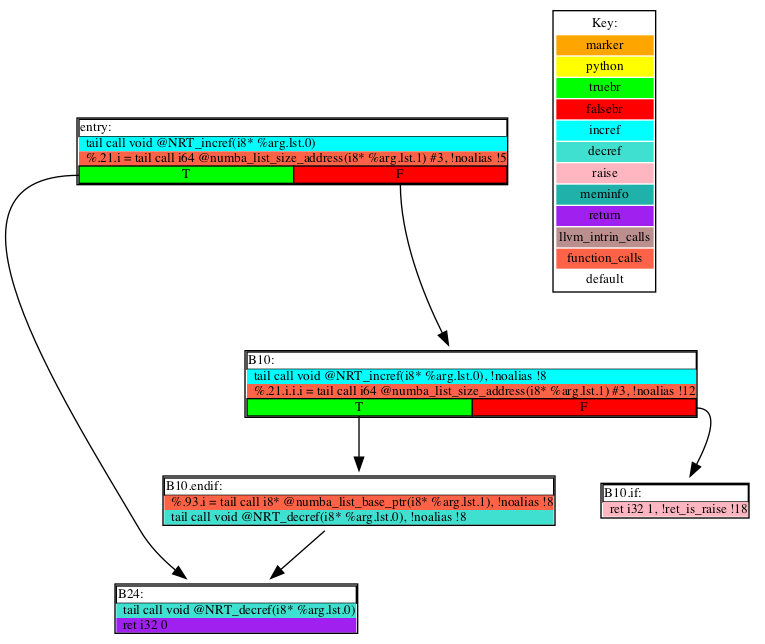

In [26]:
Image(filename='fanoutraise.png') 

### With refprune

In [27]:
!NUMBA_LLVM_REFPRUNE_FLAGS=per_bb,diamond,fanout,fanout_raise python fanoutraise.py

PruneStats(basicblock=4, diamond=0, fanout=0, fanout_raise=3)


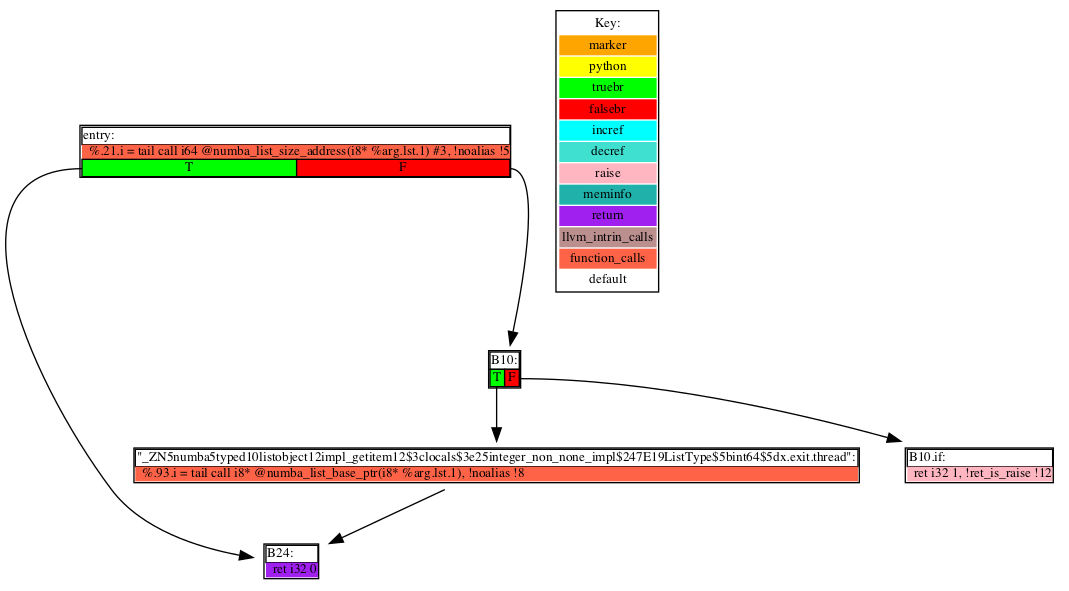

In [28]:
Image(filename='fanoutraise.png') 

Numba emits the exception raising exit in LLVM IR as `ret i32 1, !ret_is_raise !12`. The `!ret_is_raise` is the metadata used to annotate the raising exit. The first fanout+raise subgraph consists of the blocks `B10`, `_ZN5numba....exit.thread` and `B10.if`. The second adds the remaining blocks of the function. The `B10.if` raising block is shared in the two subgraphs.

### Implementation notes

This pattern is largely the same as the fanout pattern with an additional condition to accept subtrees that exit the function due to raising an exception, as marked by the `!ret_is_raise` metadata.